# imports & settings

In [2]:
import numpy as np
import pandas as pd
%precision %.3f
from os.path import join
from glob import glob
from tqdm import tqdm
import ntpath 
from copy import deepcopy
import pytz
TZ = pytz.FixedOffset(540) # GMT+09:00; Asia/Seoulsilent

import sys  
sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
import utils
from utils import *
import dataset
from feature_preprocessing import impute_support_features, impute, normalization

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn import metrics 
from sklearn.metrics import (
        plot_confusion_matrix,log_loss, balanced_accuracy_score, accuracy_score
        , f1_score, make_scorer, precision_score, recall_score, confusion_matrix, roc_auc_score
)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import catboost
import warnings
from functools import reduce

import matplotlib
matplotlib.rc('font', size=22)
from matplotlib import pyplot as plt


RANDOM_STATE=utils.RANDOM_STATE
DATAROOT = utils.DATAROOT
BALANCED_TRAINING = True
ALREADY_EXTRACTED_SUBFEATURES = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Function definitions for classification experiment

### metrics

In [3]:
def perf_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    y_pred_cls = np.rint(y_pred)    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        acc, acc_bal = accuracy_score(y_true, y_pred_cls), balanced_accuracy_score(y_true, y_pred_cls)
        f1_score = metrics.f1_score(
            y_true=y_true, y_pred=y_pred_cls,average='binary',pos_label=1)
        auc = metrics.roc_auc_score(
            y_true=y_true, y_score=y_pred, average='macro'
        )
    return dict(
        ACC=acc*100, ACC_BAL=acc_bal*100, F1_score = f1_score*100, AUC=auc
    )

    
def group_inner_split(X_train,y_train, pids):
    inner_splitter = GroupKFold(n_splits=5)
    for dev_index, val_index in inner_splitter.split(X_train, y_train, groups = pids):
        return dev_index, val_index

def stratified_inner_split(X_train,y_train):
    inner_splitter = StratifiedKFold(n_splits=5)
    for dev_index, val_index in inner_splitter.split(X_train, y_train):
        return dev_index, val_index

    
    
def get_feature_names(df):
    return df.columns[df.columns.str.contains('#')].to_list()

def univariate_selection(X,y, topq):
    X_new = SelectKBest(chi2, k=topq).fit_transform(X, y)
    return X_new

### classifiers

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from skfeature.function.similarity_based import fisher_score
import xgboost as xgb


classifiers = {
    'lr':LogisticRegression(random_state = RANDOM_STATE, max_iter=500 ),
    'lr_lasso_C=0.1':LogisticRegression(
        penalty='l1', solver='saga'
        ,random_state = RANDOM_STATE, max_iter=500
        , C=0.1
    ),
    'lr_lasso_C=0.01':LogisticRegression(
        penalty='l1', solver='saga'
        ,random_state = RANDOM_STATE, max_iter=500
        , C=0.01
    ),
    'lr_lasso_C=0.1_maxiter=1000':LogisticRegression(
        penalty='l1', solver='saga'
        ,random_state = RANDOM_STATE, max_iter=1000
        , C=0.1
    ),
    'knn':KNeighborsClassifier(),
    'svm':SVC(probability=True),
    'gp':GaussianProcessClassifier(),
    'dt':DecisionTreeClassifier(random_state = RANDOM_STATE),
    'rf':RandomForestClassifier(random_state = RANDOM_STATE),
    'mlp':MLPClassifier(),
    'adaboost':AdaBoostClassifier(),
    'gnb':GaussianNB(),
    'qda':QuadraticDiscriminantAnalysis(),
    'catboost': catboost.CatBoostClassifier(
        random_seed=RANDOM_STATE, eval_metric='AUC'
    )    
    #,'xgboost':xgb.Booster()
    }

classifier_names = {
    'lr':'LogisticRegression'
    ,'lr_lasso_C=0.1':'lr_lasso_C=0.1'
    ,'lr_lasso_C=0.01':'lr_lasso_C=0.01'
    ,'lr_lasso_C=0.1_maxiter=1000':'lr_lasso_C=0.1_maxiter=1000'
    
    ,'knn':'KNeighborsClassifier',
    'svm':'SVM',
    'gp':'GaussianProcess',
    'dt':'DecisionTree',
    'rf':'RandomForest',
    'mlp':'Multi-layer Perceptron',
    'adaboost':'AdaBoost',
    'gnb':'Gaussian Naive Bayes',
    'qda':'QuadraticDiscriminantAnalysis',
    'catboost':'CatBoost'
    #,'xgboost':'XGBoost'
}




/home/ubuntu/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


### run_classification

In [5]:


def run_classification(df, use_ray = True,  cat_features=None
    , classifier_name='catboost',
    feature_selection = None, experiment_name=''
) :                

    X = df[get_feature_names(df)]    
    y = df['receptivity'].replace({'receptive':1,'non-receptive':0}) 
    pids = df['pid']


    loso_results = LOSO(
        X,y, pids, feature_selection=feature_selection,
        cat_features=cat_features,
        classifier_name=classifier_name
        ,use_ray=use_ray
    )
    logo_results = LOGO_5fold(
        X,y, pids, feature_selection=feature_selection,
        cat_features=cat_features,
        classifier_name=classifier_name
        ,use_ray=use_ray
    )
    
    results = pd.concat([
        loso_results
        ,logo_results
    ])
    results.insert(
        results.shape[1], 'experiment',experiment_name     
    )
    return results
    


### CV

In [6]:


def LOGO_5fold(
    X,y, pids, cat_features=None, classifier_name='catboost',
    feature_selection = None
    , use_ray=False
):
    
    splitter =  GroupKFold(
        n_splits=5
    )
    func = ray.remote(run_trial).remote if use_ray else run_trial

    results = []    
    for i, (train_index, test_index) in tqdm(
        enumerate(splitter.split(X, y, groups=pids))):        
        results.append(func(
                X,y, pids, train_index,test_index,
                cat_features=cat_features, classifier_name=classifier_name,
                feature_selection = feature_selection,verbose=False
        )) 
    results = ray.get(results) if use_ray else results
    results = pd.DataFrame(results).set_index('test_pid')    
    results.insert(results.shape[1],'CV_TYPE','LOGO_5fold')
    return results


def LOSO(
        X,y, pids, cat_features=None, classifier_name='catboost',
        feature_selection = None
        ,use_ray=False
    ):
    
    splitter =  GroupKFold(
        n_splits=len(np.unique(pids))
    )
    func = ray.remote(run_trial).remote if use_ray else run_trial
    
    results = []    
    for i, (train_index, test_index) in tqdm(
        enumerate(splitter.split(X, y, groups=pids))):        
        results.append(func(X,y, pids, train_index,test_index,
                            cat_features=cat_features, classifier_name=classifier_name,
                             feature_selection = feature_selection,verbose=False))    
    results = ray.get(results) if use_ray else results
    results = pd.DataFrame(results).set_index('test_pid')    
    results.insert(results.shape[1],'CV_TYPE','LOSO')
    return results

### run_trial

In [8]:
from sklearn.linear_model import  Lasso
def run_trial(X, y,pids,  train_index,test_index, verbose,            
              feature_selection = None, cat_features=None, 
              classifier_name='catboost'):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    if BALANCED_TRAINING:
        # from imblearn.under_sampling import RandomUnderSampler
        # rus = RandomUnderSampler(random_state=RANDOM_STATE)
        # X_train, y_train = rus.fit_resample(X_train, y_train)
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=RANDOM_STATE)
        X_train, y_train = ros.fit_resample(X_train, y_train)

    
    if feature_selection['status']:
        if feature_selection['method']=='fisher_score':
            keep_ratio=feature_selection['keep_ratio']
            num_features_to_keep = int(keep_ratio*X_train.shape[1])            
            score = fisher_score.fisher_score(X_train.values, y_train.values)
        
            idx = fisher_score.feature_ranking(score)        
            X_train = X_train.iloc[:, np.array(idx[0:num_features_to_keep])]
        elif feature_selection['method']=='LASSO':
            cv = StratifiedKFold(shuffle= True, random_state=RANDOM_STATE)
    
            classifier = Lasso(tol=1e-3)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                classifier.fit(X=X_train, y=y_train)
            coef=np.abs(classifier.coef_)
            I = coef.argsort()
            keep_ratio=feature_selection['keep_ratio']
            num_features_to_keep = int(keep_ratio*X_train.shape[1])            

            X_train =  X_train[X_train.columns[I[-1*num_features_to_keep:]]]
            
            
        
    feature_names =X_train.columns.tolist()
    if verbose:  
        print("X_train.shape",X_train.shape)

    clf = classifiers[classifier_name]

    if classifier_name=='catboost':
                
        d_train = catboost.Pool(
            data = X_train,
            label = y_train,
            feature_names = feature_names,
            cat_features = cat_features
        )
        
        clf.fit(X = d_train,          
           verbose_eval=False,
           early_stopping_rounds=20,
                #plot=True
        )
    else:
        clf.fit(X_train, y_train)

        
    prob = clf.predict_proba(X.iloc[test_index][feature_names])[:,1]
    test_metrics = perf_metrics(y.iloc[test_index], prob)    

    prob = clf.predict_proba(X.iloc[train_index][feature_names])[:,1]
    train_metrics = perf_metrics(y.iloc[train_index], prob)

    test_pid = pids.iloc[test_index].unique()[0]    
    
    res = {'test_pid':test_pid}
    res.update({f'TEST_{k}':v  for k,v in test_metrics.items()})
    res.update({f'TRAIN_{k}':v  for k,v in train_metrics.items()})
    return res    
    # return {'test_pid':test_pid, 'test_bal_acc':test_metrics['ACC_BAL'],
    #     'train_bal_acc':train_metrics['ACC_BAL']    
    # }


# Data Split

In [9]:

LABEL_DTYPES = {
            'valence':float
            ,'arousal': float
            ,'attention': float
            ,'stress': float
            ,'duration': float
            ,'change': float
            , 'pid':str            
        }
labels = pd.read_csv(
    join(DATAROOT,'binned_esm_data.csv'), 
    dtype=LABEL_DTYPES,
    parse_dates=['timestamp']
).set_index(['pid','timestamp'])

pids = labels.index.get_level_values('pid').unique().tolist()
N = len(pids)
r = .5 # rule mining pariticpants ratio
arm_pids = pids[:int(N*r)]

labels_arm = labels[labels.index.get_level_values('pid').isin(arm_pids)]
labels_ml = labels[~labels.index.get_level_values('pid').isin(arm_pids)]
labels_arm.shape, labels_ml.shape

((1580, 20), (1754, 20))

In [10]:
labels_arm.index.get_level_values('pid').nunique(), labels_ml.index.get_level_values('pid').nunique()

(36, 37)

# RuleGenerateSet


In [28]:
labels_arm.receptivity.value_counts()

receptive        913
non-receptive    667
Name: receptivity, dtype: int64

In [29]:
labels_ml.receptivity.value_counts()

receptive        1025
non-receptive     729
Name: receptivity, dtype: int64

In [10]:

print(f'num of interventions: {labels_arm.shape[0]}')
num_participants = labels_arm.index.get_level_values('pid').nunique()


sub_winsize = 20 # min
print('number of sub-windows (transactions) for the given feature:\n num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize')
num_participants*utils.COLLECTION_DAYS*utils.COLLECTION_HOURS*utils.MIN_IN_HOUR//sub_winsize

num of interventions: 1580
number of sub-windows (transactions) for the given feature:
 num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize


9072

### Select window size
- which window size
    - 40  MIN
    - 80  MIN
    

- how many sub window size
    - 2
    - 4
    - 8

In [12]:
sub_features_d={}
windows = {
    '40MIN': 40 * 60
    ,'80MIN': 80 * 60
    ,'160MIN': 160 * 60
}
num_sub_windows = [2,4,8]


#### Extract sub features

In [13]:
if not ALREADY_EXTRACTED_SUBFEATURES:
    with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=40):    
        for i,nsub in enumerate(num_sub_windows):
            for window_name, window_size  in windows.items():
                print(f'{window_name} at {nsub} subwindows')
                sub_features = dataset.parallellize_extract_sub(
                    labels=labels_arm, 
                    w_name=window_name,
                    w_size = window_size,
                    use_ray=True
                    ,num_sub=nsub
                )
                sub_features.to_csv(f'feature/arm/{window_name}_{nsub}.csv')
                sub_features_d[(nsub,window_name)]=sub_features

#### find missing features per combination

In [14]:


measurement = pd.DataFrame(
    columns=['window size','number of subwindows'
             ,'percentage of missing features']
)
with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=40):    
    for i, (window_name, window_size) in enumerate(windows.items()):
        for _ ,nsub in enumerate(num_sub_windows):
        
            sub_features = pd.read_csv(
                f'feature/arm/{window_name}_{nsub}.csv'
            ).set_index(['pid','timestamp','sub_timestamp']) #sub_features_d[(nsub,window_name)]
            sub_features = impute_support_features(sub_features)
            ds = sub_features.isnull().sum(axis=0).sort_values(ascending=True).values/sub_features.shape[1]
            ds = ds/(len(sub_features))
            
            measurement = pd.concat(
                [
                    measurement
                    ,pd.DataFrame({
                        'window size':[window_name]
                        ,'number of subwindows':[nsub]
                        ,'percentage of missing features':[ds.sum()*100]
                    })
                ]
                , ignore_index=True
                
            )

pd.set_option("display.precision", 2)
measurement.to_csv(f'setting/missing_feature_for_each_combinations.csv', index=False)
measurement

,window size,number of subwindows,percentage of missing features
0,40MIN,2,1.95
1,40MIN,4,1.89
2,40MIN,8,1.86
3,80MIN,2,2.32
4,80MIN,4,2.18
5,80MIN,8,2.11
6,160MIN,2,3.29
7,160MIN,4,2.97
8,160MIN,8,2.84


### aggregated features 
#### compute

In [16]:
window_name, nsub = '80MIN', 4 # selected above
sub_features = pd.read_csv(
    f'feature/arm/{window_name}_{nsub}.csv'
    ,dtype={'pid':str}
    ,parse_dates=['timestamp','sub_timestamp']
).set_index(['pid','timestamp','sub_timestamp'])


sub_features_preprocessed = impute_support_features(
        normalization(sub_features)
)


agg_feature = sub_features_preprocessed.groupby(['pid','timestamp']).agg(
    ['mean','std']
)
agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
agg_feature

appUsage_appPackage#80MIN#20MIN#ETP|mean  \
pid  timestamp                                                       
1501 2019-05-16 12:17:02                                      0.02   
     2019-05-16 13:46:27                                      0.23   
     2019-05-16 14:28:19                                      0.12   
     2019-05-16 15:12:59                                      0.18   
     2019-05-16 16:41:48                                      0.50   
...                                                            ...   
729  2019-05-14 18:10:13                                      0.44   
     2019-05-14 18:54:15                                      0.46   
     2019-05-14 19:33:13                                      0.48   
     2019-05-14 20:16:19                                      0.59   
     2019-05-14 21:02:23                                      0.40   

                          appUsage_appPackage#80MIN#20MIN#ETP|std  \
pid  timestamp                                                      
1501 2019-05-16 12:17:02                                     0.03   
     2019-05-16 13:46:27                                     0.20   
     2019-05-16 14:28:19                                     0.19   
     2019-05-16 15:12:59                                     0.28   
     2019-05-16 16:41:48                                     0.10   
...                                                           ...   
729  2019-05-14 18:10:13                                     0.17   
     2019-05-14 18:54:15                                     0.20   
     2019-05-14 19:33:13                                     0.17   
     2019-05-14 20:16:19                                     0.11   
     2019-05-14 21:02:23                                     0.23   

                          appUsage_appPackage#80MIN#20MIN#ASC|mean  \
pid  timestamp                                                       
1501 2019-05-16 12:17:02                                      0.01   
     2019-05-16 13:46:27                                      0.07   
     2019-05-16 14:28:19                                      0.04   
     2019-05-16 15:12:59                                      0.10   
     2019-05-16 16:41:48                                      0.15   
...                                                            ...   
729  2019-05-14 18:10:13                                      0.14   
     2019-05-14 18:54:15                                      0.17   
     2019-05-14 19:33:13                                      0.12   
     2019-05-14 20:16:19                                      0.18   
     2019-05-14 21:02:23                                      0.15   

                          appUsage_appPackage#80MIN#20MIN#ASC|std  \
pid  timestamp                                                      
1501 2019-05-16 12:17:02                                     0.02   
     2019-05-16 13:46:27                                     0.06   
     2019-05-16 14:28:19                                     0.05   
     2019-05-16 15:12:59                                     0.13   
     2019-05-16 16:41:48                                     0.04   
...                                                           ...   
729  2019-05-14 18:10:13                                     0.07   
     2019-05-14 18:54:15                                     0.10   
     2019-05-14 19:33:13                                     0.07   
     2019-05-14 20:16:19                                     0.05   
     2019-05-14 21:02:23                                     0.10   

                          appUsage_appCategory#80MIN#20MIN#ETP|mean  \
pid  timestamp                                                        
1501 2019-05-16 12:17:02                                       0.02   
     2019-05-16 13:46:27                                       0.16   
     2019-05-16 14:28:19                                       0.13   
     2019-05-16 15:12:59                             

#### Feature selection

##### missing count thresholding

Text(0, 0.5, 'Percentage of missing cases')

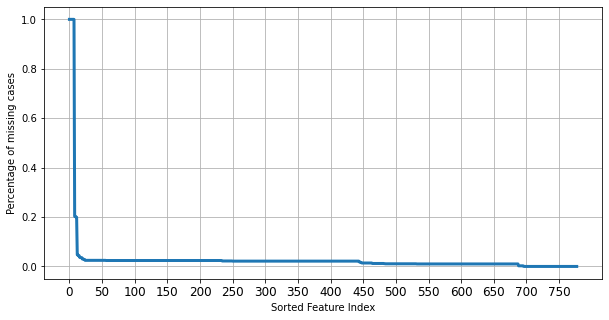

In [17]:
ds_missing = agg_feature.isnull().sum(axis=0)/len(agg_feature)
#thresholding
agg_feature_percent_missing  = agg_feature.loc[:,(ds_missing[ds_missing<.2]).index]

plt.figure(figsize=(10,5))
N, D = agg_feature.shape
ds_missing.sort_values(ascending=False).plot(linewidth=3)
I = np.arange(0,D,50)
plt.xticks(I,I, fontsize=12);
plt.grid()
plt.xlabel('Sorted Feature Index')
plt.ylabel('Percentage of missing cases')


##### varience thresholding

In [18]:
STD_cutoff_threshold = agg_feature_percent_missing.std().sort_values().iloc[280]

agg_feature_good_variance = agg_feature_percent_missing.iloc[
    :,agg_feature_percent_missing.std().values>STD_cutoff_threshold
]
agg_feature_good_variance.shape[1],'features kept ',agg_feature_percent_missing.shape[1]

(487, 'features kept ', 768)

Text(200, 0.25, 'Cut off threshold')

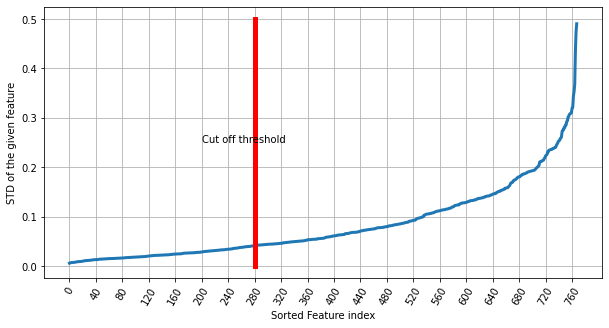

In [19]:

plt.figure(figsize=(10,5))
agg_feature_percent_missing.std().sort_values().plot(rot=60, linewidth=3)

plt.grid()
plt.ylabel('STD of the given feature')
plt.xlabel('Sorted Feature index')

I = np.arange(0,agg_feature_percent_missing.shape[1],40)
plt.xticks(I,I)

cutoff_threshold = 280
plt.plot([cutoff_threshold,cutoff_threshold],[0,.5],color='red', linewidth=5)
plt.text(200,0.25,'Cut off threshold')


##### Pairwise Correlation

###### prepare features order
- features highly correlated with target variable should come first in corr matrix


In [20]:
corr_with_target = pd.merge(
    labels_arm[['disturbance']],
    agg_feature_good_variance
    ,left_index=True, right_index=True
).corr()['disturbance'].abs().sort_values(ascending=False)

importance_order = corr_with_target.index.to_list()[1:]
importance_order

['ringer#80MIN#20MIN#SUP:RINGER_MODE_NORMAL|mean',
 'data_RX2TX#80MIN#20MIN#MAX|std',
 'battery_plugState#80MIN#20MIN#SUP:WIRELESS|mean',
 'data_RX2TX#80MIN#20MIN#VAR|std',
 'battery_plugState#80MIN#20MIN#SUP:WIRELESS|std',
 'data_RX2TX#80MIN#20MIN#MAX|mean',
 'data_RX2TX#80MIN#20MIN#ASC|std',
 'screen#80MIN#20MIN#ASC|mean',
 'accelerometer_Y#80MIN#20MIN#MED|mean',
 'unlock#80MIN#20MIN#SUP:UNLOCK|mean',
 'accelerometer_Y#80MIN#20MIN#AVG|mean',
 'accelerometer_Y#80MIN#20MIN#LTI|mean',
 'appUsage_appCategory#80MIN#20MIN#SUP:Tools|mean',
 'appUsage_appPackage#80MIN#20MIN#ETP|mean',
 'wifi_numConnections#80MIN#20MIN#CID|mean',
 'connection_type#80MIN#20MIN#SUP:MOBILE|mean',
 'data_RX2TX#80MIN#20MIN#ASC|mean',
 'appUsage_appCategory#80MIN#20MIN#SUP:Tools|std',
 'data_TX#80MIN#20MIN#ASC|std',
 'accelerometer_Y#80MIN#20MIN#AVG|std',
 'data_TX#80MIN#20MIN#MAX|mean',
 'ringer#80MIN#20MIN#SUP:RINGER_MODE_SILENT|mean',
 'appUsage_appCategory#80MIN#20MIN#ETP|mean',
 'activity_event#80MIN#20MIN#SUP

In [21]:
Matrix = agg_feature_good_variance[importance_order].corr()
Matrix

,ringer#80MIN#20MIN#SUP:RINGER_MODE_NORMAL|mean,data_RX2TX#80MIN#20MIN#MAX|std,battery_plugState#80MIN#20MIN#SUP:WIRELESS|mean,data_RX2TX#80MIN#20MIN#VAR|std,battery_plugState#80MIN#20MIN#SUP:WIRELESS|std,data_RX2TX#80MIN#20MIN#MAX|mean,data_RX2TX#80MIN#20MIN#ASC|std,screen#80MIN#20MIN#ASC|mean,accelerometer_Y#80MIN#20MIN#MED|mean,unlock#80MIN#20MIN#SUP:UNLOCK|mean,...,accelerometer_Z#80MIN#20MIN#ASC|std,connection_type#80MIN#20MIN#SUP:WIFI|mean,bandHeartRate_BPM#80MIN#20MIN#MINLAG|mean,wifi_numConnections#80MIN#20MIN#MINLAG|std,bandSkinTemperature_temperature#80MIN#20MIN#MINLAG|std,accelerometer_X#80MIN#20MIN#MAXLAG|std,bandCalory_burned#80MIN#20MIN#SKW|mean,bandDistance_pace#80MIN#20MIN#ASC|mean,accelerometer_Z#80MIN#20MIN#MINLAGVAL|mean,ringer#80MIN#20MIN#SUP:RINGER_MODE_VIBRATE|std
ringer#80MIN#20MIN#SUP:RINGER_MODE_NORMAL|mean,1.00,-9.05e-02,3.81e-01,-8.39e-02,0.36,-9.03e-02,-6.14e-02,-0.13,-2.23e-01,4.80e-02,...,2.10e-03,8.04e-02,-3.96e-03,-1.25e-02,1.56e-02,2.01e-02,4.79e-02,-3.69e-02,5.16e-02,5.75e-02
data_RX2TX#80MIN#20MIN#MAX|std,-0.09,1.00e+00,-2.82e-02,6.56e-01,-0.02,6.66e-01,5.93e-01,0.21,1.38e-01,4.03e-02,...,1.50e-02,-1.91e-01,4.25e-03,4.30e-02,1.33e-02,-4.35e-03,3.00e-04,5.06e-02,-4.50e-02,1.57e-01
battery_plugState#80MIN#20MIN#SUP:WIRELESS|mean,0.38,-2.82e-02,1.00e+00,-3.86e-02,0.74,-4.74e-02,-2.75e-02,-0.06,-1.90e-01,2.08e-02,...,1.13e-02,4.27e-02,5.64e-03,7.61e-03,-2.17e-02,8.71e-02,-2.53e-02,-5.04e-02,2.01e-02,6.73e-03
data_RX2TX#80MIN#20MIN#VAR|std,-0.08,6.56e-01,-3.86e-02,1.00e+00,-0.04,6.53e-01,5.87e-01,0.17,8.83e-02,2.29e-02,...,-3.01e-02,-1.92e-01,4.77e-02,-9.56e-03,-6.93e-03,-4.72e-04,4.29e-03,-8.11e-04,-4.20e-02,9.73e-02
battery_plugState#80MIN#20MIN#SUP:WIRELESS|std,0.36,-2.35e-02,7.35e-01,-4.23e-02,1.00,-3.68e-02,-5.61e-03,-0.03,-1.49e-01,2.29e-02,...,5.02e-02,4.03e-02,2.66e-02,3.66e-02,-1.52e-02,3.80e-02,-1.40e-02,-3.09e-02,1.46e-02,2.74e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
accelerometer_X#80MIN#20MIN#MAXLAG|std,0.02,-4.35e-03,8.71e-02,-4.72e-04,0.04,-1.15e-02,-1.97e-02,-0.04,-3.93e-02,8.98e-03,...,-7.87e-03,3.00e-03,9.30e-02,2.32e-02,5.58e-05,1.00e+00,2.91e-02,-5.37e-02,7.20e-02,8.05e-02
bandCalory_burned#80MIN#20MIN#SKW|mean,0.05,3.00e-04,-2.53e-02,4.29e-03,-0.01,3.37e-03,1.04e-02,0.04,5.48e-02,-4.91e-02,...,3.39e-01,-3.28e-02,-2.26e-01,-4.08e-02,3.46e-01,2.91e-02,1.00e+00,2.66e-01,2.38e-01,3.42e-02
bandDistance_pace#80MIN#20MIN#ASC|mean,-0.04,5.06e-02,-5.04e-02,-8.11e-04,-0.03,7.37e-03,8.66e-03,0.31,6.89e-02,6.13e-03,...,4.60e-01,-1.05e-02,-1.12e-01,-1.79e-03,2.06e-01,-5.37e-02,2.66e-01,1.00e+00,1.50e-01,5.16e-02
accelerometer_Z#80MIN#20MIN#MINLAGVAL|mean,0.05,-4.50e-02,2.01e-02,-4.20e-02,0.01,-3.87e-02,-4.68e-02,0.09,4.26e-03,8.71e-03,...,1.41e-01,2.37e-02,-4.87e-01,-3.25e-02,1.39e-01,7.20e-02,2.38e-01,1.50e-01,1.00e+00,6.14e-03


In [22]:
pd.set_option("display.precision", 2)
matplotlib.rc('font', size=22)

import seaborn as sns
sns.heatmap(
    Matrix, cmap="YlGnBu",fmt='.2f' 
    ,annot=True, mask=np.triu(np.ones_like(Matrix))
)

<AxesSubplot:>

Error in callback <function flush_figures at 0x7fe220b7cd30> (for post_execute):


KeyboardInterrupt: 

###### selection with pairwise correlation
- find features to be eliminate
- store kept features

In [23]:
PAIRWISE_CORR_THRESHOLD = 0.8
D = Matrix.shape[0]
eliminated_features = []

for r in range(D):
    featurename = Matrix.index[r]   
    if str(featurename) in eliminated_features:
        continue
    pairwise_corr = Matrix.iloc[r,:r]
    eliminated_features+= pairwise_corr[pairwise_corr>PAIRWISE_CORR_THRESHOLD].index.to_list()

kept_features_after_pairwise_correlation = list(
    set(Matrix.index.to_list()) - set(eliminated_features)
)
len(kept_features_after_pairwise_correlation)

281

###### fit classifier after eliminating multi colliniearity

In [24]:
data = pd.merge(
    labels_arm[['receptivity']],
    impute(agg_feature_good_variance[kept_features_after_pairwise_correlation])
    ,left_index=True, right_index=True
)

In [25]:
feature_selection={'status':False}
use_ray = False

measure = run_classification(
    data.reset_index(), 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

36it [00:05,  6.72it/s]
5it [00:00,  8.17it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr,55.06,54.67,59.81,0.56,75.60,75.29,78.50,0.83
LOSO,lr,55.31,56.08,53.42,0.55,74.31,74.15,77.18,0.82


##### LogReg+Lasso 

In [26]:

from random import random


clf = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=RANDOM_STATE)
clf.fit(
    data.drop(['receptivity'], axis=1)
    , data['receptivity']
)


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')

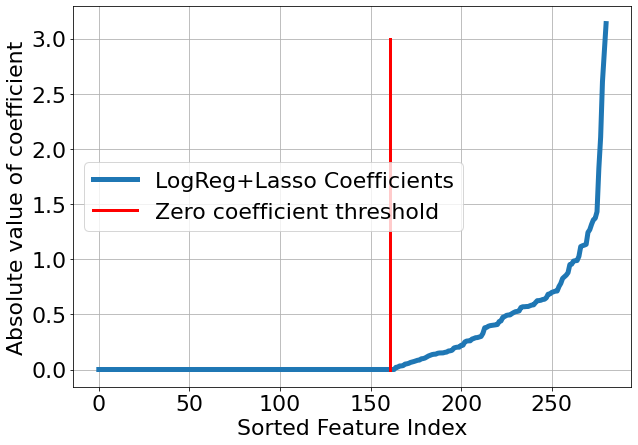

In [27]:
matplotlib.rc('font', size=22)

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(np.abs(clf.coef_[0])), linewidth=5, 
    label = 'LogReg+Lasso Coefficients'
)
plt.xlabel('Sorted Feature Index')
plt.ylabel("Absolute value of coefficient")

plt.plot(
    [161,161],[0,3], color='red', linewidth=3
    , label='Zero coefficient threshold'
)
plt.legend()


In [28]:
lasso_features = np.array(kept_features_after_pairwise_correlation)[np.abs(clf.coef_[0])>0]
len(lasso_features)

121

###### test fit

In [29]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(agg_feature_good_variance[
            #kept_features_after_pairwise_correlation
            lasso_features
        ])
        ,left_index=True, right_index=True
    ).reset_index(), 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

36it [00:03, 10.59it/s]
5it [00:00,  9.48it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,60.39,59.55,63.32,0.63,73.59,73.28,76.62,0.81
LOSO,lr-after logreg-lasso,60.26,58.97,57.51,0.59,73.09,72.86,76.14,0.80


In [30]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(agg_feature_good_variance[
            lasso_features
        ])
        ,left_index=True, right_index=True
    ).reset_index(), 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='rf-after logreg-lasso'
    , classifier_name='rf'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

36it [00:28,  1.25it/s]
5it [00:03,  1.54it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,rf-after logreg-lasso,56.82,57.22,59.96,0.59,94.68,95.44,95.21,1.0
LOSO,rf-after logreg-lasso,55.79,55.04,53.53,0.54,95.10,95.77,95.58,1.0


#### end of feature selection

In [33]:
len(lasso_features)

121

In [30]:
selected_features = lasso_features
selected_features
pd.DataFrame({
    'features1':selected_features[:40]
    ,'features2':selected_features[40:40+40]
    ,'features3':selected_features[40+40:40+40+40]
}).to_csv('selected_features.csv',index=False)

### Mine Association Rules
- on RuleGenerateSet
- select sub featurs using RuleGenerate Set
- 

#### Feature selection
- extract sub features for the selected window size
- compute aggregated features
- exclude multicolliniear features
    - select aggregated features with correlation threshold of .06 

# map selected aggregated features to subfeatures

In [31]:
selected_features_mapped = list(
    set(map(lambda x: x[:x.find('|')], selected_features))
)
selected_features_mapped = list(
    map(lambda x: x.replace('#80MIN#20MIN',''), selected_features_mapped)
)
print('sub features selected (mapped from agg. features):'
      ,len(selected_features_mapped))

sub features selected (mapped from agg. features): 102


#### extract sliding features


In [46]:
import dataset
with on_ray(object_store_memory=2e10, ignore_reinit_error=True):    
    sliding_features = dataset.parallellize_extract_sliding(
            labels=labels_arm 
            , _sw_size_in_min = 20
            , selected_features=selected_features_mapped 
        )
sliding_features = impute_support_features(sliding_features)
sliding_features.to_csv('feature/arm/sliding_features.csv')
sliding_features.isnull().sum().sort_values(ascending=False)     


100%|██████████| 36/36 [02:16<00:00,  3.78s/it]


ringer#ETP                            2159
bandUV_exposure#MINLAG                 711
bandUV_exposure#MAXLAGVAL              711
bandUV_exposure#MAX                    711
bandHeartRate_BPM#ASC                  708
                                      ... 
unlock#SUP:UNLOCK                        0
screen#SUP:SCREEN_ON                     0
battery_status#SUP:DISCHARGING           0
appUsage_appCategory#SUP:UNDEFINED       0
battery_plugState#SUP:WIRELESS           0
Length: 102, dtype: int64

In [47]:
sliding_features = pd.read_csv(
    'feature/arm/sliding_features.csv', dtype={'pid':str}
).set_index(['pid','timestamp'])

sliding_features.isnull().sum().sort_values(ascending=False)     

ringer#ETP                            2159
bandUV_exposure#MINLAG                 711
bandUV_exposure#MAXLAGVAL              711
bandUV_exposure#MAX                    711
bandHeartRate_BPM#ASC                  708
                                      ... 
unlock#SUP:UNLOCK                        0
screen#SUP:SCREEN_ON                     0
battery_status#SUP:DISCHARGING           0
appUsage_appCategory#SUP:UNDEFINED       0
battery_plugState#SUP:WIRELESS           0
Length: 102, dtype: int64

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, 'connection_type#SUP:MOBILE'),
  Text(0.0, 0, 'ringer#ETP'),
  Text(20.0, 0, 'bandAmbientLight_brightness#BEP'),
  Text(40.0, 0, 'accelerometer_X#LTI'),
  Text(60.0, 0, 'data_TX#BEP'),
  Text(80.0, 0, 'battery_level#BEP'),
  Text(100.0, 0, 'appUsage_appCategory#SUP:UNDEFINED'),
  Text(120.0, 0, '')])

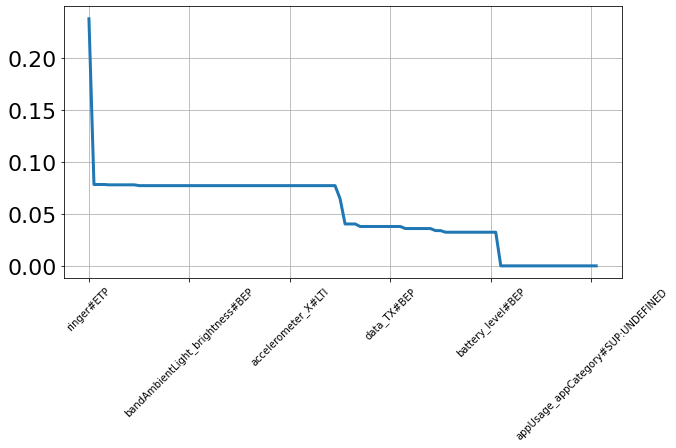

In [48]:
plt.figure(figsize=(10,5))

(sliding_features.isnull().sum(axis=0).sort_values(ascending=False)/len(sliding_features)).plot(
    linewidth=3)
plt.grid(True)
plt.xticks(rotation=45, fontsize=10)

In [52]:
imputed_sliding_features = impute(sliding_features)

/home/ubuntu/receptivity/analysis/feature_preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/receptivity/analysis/feature_preprocessing.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NAFILL=-1
/home/ubuntu/receptivity/analysis/feature_preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

#### Recode

In [54]:

    
from copy import deepcopy        
def discretize_df(data, cols, pid):
    df = deepcopy(data)
    count2 = 0
    count1 = 0
    count3 = 0
    for col in cols:
        try:
            df[col] = pd.qcut(df[col], 3, labels=["l","m","h"])
            count3 += 1
        except:
            try:
                df[col] = pd.qcut(df[col], 2, labels=["l","h"])
                count2 += 1
            except:
                df[col] = pd.qcut(df[col], 1, labels=["m"])
                count1 += 1
    print("The numbers of 1-3 labels of PID{} are: {}, {}, {}".format(pid, count1, count2, count3))
    df.insert(0,'pid',pid)
    df = df.reset_index().set_index(['pid']+data.index.names)
    return df


df_recoded = [] 
for pid in tqdm(imputed_sliding_features.index.get_level_values('pid').unique()):    
    res = discretize_df(imputed_sliding_features.loc[pid],
                        imputed_sliding_features.columns.tolist(), pid)
    df_recoded.append(res)
df_recoded = pd.concat(df_recoded)
df_recoded = df_recoded.astype('str').fillna('missing').astype('category')
df_recoded.head()

The numbers of 1-3 labels of PID1501 are: 31, 7, 64
The numbers of 1-3 labels of PID1508 are: 39, 7, 56


The numbers of 1-3 labels of PID1510 are: 34, 10, 58
The numbers of 1-3 labels of PID1515 are: 36, 11, 55


The numbers of 1-3 labels of PID1516 are: 33, 6, 63
The numbers of 1-3 labels of PID1521 are: 30, 7, 65


The numbers of 1-3 labels of PID1523 are: 33, 6, 63
The numbers of 1-3 labels of PID1525 are: 31, 6, 65


The numbers of 1-3 labels of PID1526 are: 31, 6, 65
The numbers of 1-3 labels of PID3001 are: 37, 26, 39


The numbers of 1-3 labels of PID3002 are: 27, 14, 61
The numbers of 1-3 labels of PID3003 are: 36, 8, 58


The numbers of 1-3 labels of PID3005 are: 30, 16, 56
The numbers of 1-3 labels of PID3007 are: 39, 7, 56


The numbers of 1-3 labels of PID3012 are: 28, 11, 63
The numbers of 1-3 labels of PID3013 are: 32, 5, 65


The numbers of 1-3 labels of PID3014 are: 25, 72, 5
The numbers of 1-3 labels of PID3015 are: 31, 7, 64


The numbers of 1-3 labels of PID3016 are: 35, 7, 60
The numbers of 1-3 labels of PID3019 are: 37, 4, 61


The numbers of 1-3 labels of PID3024 are: 43, 10, 49
The numbers of 1-3 labels of PID3027 are: 36, 10, 56


The numbers of 1-3 labels of PID3028 are: 36, 10, 56
The numbers of 1-3 labels of PID701 are: 35, 7, 60


The numbers of 1-3 labels of PID703 are: 39, 7, 56
The numbers of 1-3 labels of PID704 are: 34, 4, 64


The numbers of 1-3 labels of PID705 are: 35, 6, 61
The numbers of 1-3 labels of PID711 are: 28, 12, 62


The numbers of 1-3 labels of PID716 are: 35, 4, 63
The numbers of 1-3 labels of PID717 are: 35, 11, 56


The numbers of 1-3 labels of PID718 are: 36, 10, 56
The numbers of 1-3 labels of PID722 are: 31, 13, 58


The numbers of 1-3 labels of PID723 are: 22, 50, 30
The numbers of 1-3 labels of PID727 are: 33, 6, 63


100%|██████████| 36/36 [00:03<00:00,  9.12it/s]

The numbers of 1-3 labels of PID728 are: 32, 5, 65
The numbers of 1-3 labels of PID729 are: 35, 3, 64


appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp                                                           
1501 2019-05-16 10:20:00                                             m   
     2019-05-16 10:40:00                                             l   
     2019-05-16 11:00:00                                             m   
     2019-05-16 11:20:00                                             m   
     2019-05-16 11:40:00                                             l   

                         appUsage_appCategory#SUP:Tools  \
pid  timestamp                                            
1501 2019-05-16 10:20:00                              l   
     2019-05-16 10:40:00                              l   
     2019-05-16 11:00:00                              l   
     2019-05-16 11:20:00                              l   
     2019-05-16 11:40:00                              l   

                         appUsage_appCategory#SUP:UNDEFINED  \
pid  timestamp                                                
1501 2019-05-16 10:20:00                                  m   
     2019-05-16 10:40:00                                  h   
     2019-05-16 11:00:00                                  h   
     2019-05-16 11:20:00                                  h   
     2019-05-16 11:40:00                                  h   

                         battery_temperature#MAX battery_temperature#BEP  \
pid  timestamp                                                             
1501 2019-05-16 10:20:00                       m                       m   
     2019-05-16 10:40:00                       l                       l   
     2019-05-16 11:00:00                       l                       h   
     2019-05-16 11:20:00                       l                       h   
     2019-05-16 11:40:00                       l                       h   

                         battery_temperature#MAXLAG  \
pid  timestamp                                        
1501 2019-05-16 10:20:00                          m   
     2019-05-16 10:40:00                          m   
     2019-05-16 11:00:00                          m   
     2019-05-16 11:20:00                          m   
     2019-05-16 11:40:00                          m   

                         battery_temperature#MAXLAGVAL  \
pid  timestamp                                           
1501 2019-05-16 10:20:00                             m   
     2019-05-16 10:40:00                             m   
     2019-05-16 11:00:00                             m   
     2019-05-16 11:20:00                             h   
     2019-05-16 11:40:00                             m   

                         battery_temperature#LTS battery_level#MIN  \
pid  timestamp                                                       
1501 2019-05-16 10:20:00                       l                 h   
     2019-05-16 10:40:00                       l                 h   
     2019-05-16 11:00:00                       m                 h   
     2019-05-16 11:20:00                       m                 h   
     2019-05-16 11:40:00                       m                 h   

                         battery_level#BEP  ... bandDistance_speed#MAX  \
pid  timestamp                              ...                          
1501 2019-05-16 10:20:00                 l  ...                      l   
     2019-05-16 10:40:00                 l  ...                      l   
     2019-05-16 11:00:00                 l  ...                      l   
     2019-05-16 11:20:00                 m  ...                      l   
     2019-05-16 11:40:00                 h  ...                      l   

                         activity_event#SUP:WALKING  \
pid  timestamp                                        
1501 2019-05-16 10:20:00                          m   
     2019-05-16 10:40:00                          m   
     2019-05-16 11:00:00                          m   
     2019-05-16 11:20:00               

### convert to transaction list

In [56]:
dataset = []
for i, r in df_recoded.iterrows():
    transaction = [f'{featurename}:{value}' 
                   for featurename, value in zip(r.index, r.values)]
    dataset.append(transaction)
len(dataset)
    

9072

#### mine Rules

In [62]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth


# dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
#            ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
#            ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
#            ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
#            ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df


,accelerometer_X#LTI:h,accelerometer_X#LTI:l,accelerometer_X#LTI:m,accelerometer_X#MAX:h,accelerometer_X#MAX:l,accelerometer_X#MAX:m,accelerometer_X#MINLAG:h,accelerometer_X#MINLAG:l,accelerometer_X#MINLAG:m,accelerometer_Y#LTI:h,...,wifi_numConnections#MAX:m,wifi_numConnections#MAXLAGVAL:h,wifi_numConnections#MAXLAGVAL:l,wifi_numConnections#MAXLAGVAL:m,wifi_numConnections#MED:h,wifi_numConnections#MED:l,wifi_numConnections#MED:m,wifi_numConnections#MINLAG:h,wifi_numConnections#MINLAG:l,wifi_numConnections#MINLAG:m
0,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
4,False,False,True,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,False,True,False,False,True,False,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False
9068,False,True,False,False,False,True,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False
9069,False,True,False,False,False,True,True,False,False,False,...,False,False,True,False,False,True,False,False,True,False
9070,True,False,False,False,False,True,False,True,False,False,...,False,False,False,True,False,True,False,False,True,False


In [63]:
frequent_itemsets = fpgrowth(
    df, min_support=0.95, use_colnames=True,
    max_len=3
)
### alternatively:
#frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
#frequent_itemsets = fpmax(df, min_support=0.6, use_colnames=True)

frequent_itemsets

,support,itemsets
0,1.00,(unlock#SUP:UNLOCK:m)
1,1.00,(battery_status#SUP:FULL:m)
2,1.00,(appUsage_appCategory#SUP:Media/Entertainment:m)
3,1.00,(bandUV_indexLevel#SUP:LOW:m)
4,1.00,(bandUV_indexLevel#SUP:NONE:m)
...,...,...
940,0.96,"(bandUV_indexLevel#SUP:LOW:m, connection_statu..."
941,0.96,"(bandUV_indexLevel#SUP:LOW:m, unlock#SUP:UNLOC..."
942,0.96,"(battery_status#SUP:FULL:m, connection_status#..."
943,0.96,"(unlock#SUP:UNLOCK:m, connection_status#ETP:m,..."


In [64]:
from pycaret.arules import *

ModuleNotFoundError: No module named 'pycaret'

In [279]:
%load_ext rpy2.ipython

In [280]:
%%R

library(tibble)
library(dplyr)
library(forcats)
library(tidyr)
library(purrr)
library(psych)
library(stringr)
library(ggplot2)

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='Arial',
) +
theme(
    axis.title.x=element_text(colour="grey20",size=13,angle=0,hjust=.5,vjust=.5, face="bold"),
    axis.title.y=element_text(colour="grey20",size=13,angle=90,hjust=.5,vjust=1, face="bold"),
    axis.text.x=element_text(colour="grey20",size=11,angle=0,hjust=.5,vjust=.5),
    axis.text.y=element_text(colour="grey20",size=11,angle=0,hjust=.5,vjust=.5),
    strip.text.x=element_text(colour="grey20",size=13,angle=0,hjust=0.5,vjust=.25, face="bold"),
    strip.text.y=element_text(colour="grey20",size=13,angle=270,hjust=.5,vjust=.5, face="bold"),
    legend.title=element_text(colour="grey20",size=13,angle=0,hjust=0.5,vjust=.5,face="bold"),
    legend.position='top'
)


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Want to understand how all the pieces fit together? Read R for Data
Science: https://r4ds.had.co.nz/

R[write to console]: 
Attaching package: ‘ggplot2’


R[write to console]: The following objects are masked from ‘package:psych’:

    %+%, alpha




In [281]:
%%R -i df_recoded
library('arules')
library('arulesViz')
library('stringr')
library('tidyverse')
library('glue')

data <- as.data.frame((df_recoded))

for (mlen in 2:10){
    print('------------')
    print(glue("mlen:{mlen}"))
    rules <- apriori(data, parameter=list( supp=.3, conf=0.3,  minlen=2,maxlen=mlen))
        
    topRules = head(rules, n = 1000, by = "lift")
    d <- as(topRules, "data.frame")
    write.csv(d, file.path('rules',glue("rules1000-mlen_{mlen}.csv")))
}


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘arules’


R[write to console]: The following object is masked from ‘package:dplyr’:

    recode


R[write to console]: The following objects are masked from ‘package:base’:

    abbreviate, write


R[write to console]: ── Attaching packages ─── tidyverse 1.3.0 ──

R[write to console]: ✔ readr 1.4.0     

R[write to console]: ── Conflicts ────── tidyverse_conflicts() ──
✖ ggplot2::%+%()   masks psych::%+%()
✖ ggplot2::alpha() masks psych::alpha()
✖ Matrix::expand() masks tidyr::expand()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ Matrix::pack()   masks tidyr::pack()
✖ arules::recode() masks dplyr::recode()
✖ Matrix::unpack() masks tidyr::unpack()

R[write to console]: 
Attaching package: ‘glue’


R[wri

[1] "------------"
mlen:2
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5     0.3      2
 maxlen target  ext
      2  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 1915 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[96 item(s), 6384 transaction(s)] done [0.02s].
sorting and recoding items ... [56 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 done [0.01s].
writing ... [968 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].
[1] "------------"
mlen:3
Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.3    0.1    1 none FALSE            TRUE       5     0.3      2
 maxlen target  ext
      3  rules TRUE

Algorithmic co

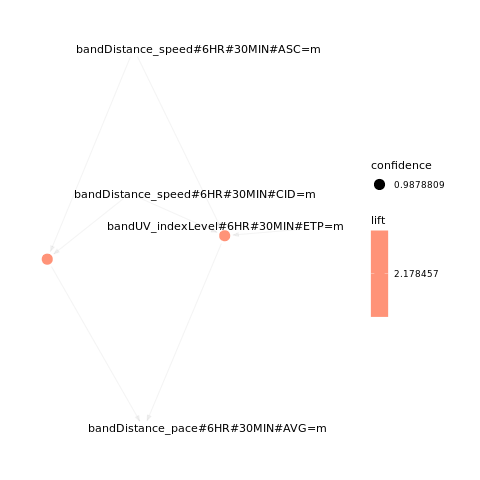

In [282]:
%%R
plot(head(topRules,n=2), method = "graph", 
     measure = "confidence", shading = "lift")

In [289]:
%%R
inspect(head(topRules,n=10))

     lhs                                                              rhs                                   support confidence coverage     lift count
[1]  {bandDistance_speed#6HR#30MIN#ASC=m,                                                                                                             
      bandDistance_speed#6HR#30MIN#CID=m}                          => {bandDistance_pace#6HR#30MIN#AVG=m} 0.4468985  0.9878809 0.452381 2.178457  2853
[2]  {bandUV_indexLevel#6HR#30MIN#ETP=m,                                                                                                              
      bandDistance_speed#6HR#30MIN#ASC=m,                                                                                                             
      bandDistance_speed#6HR#30MIN#CID=m}                          => {bandDistance_pace#6HR#30MIN#AVG=m} 0.4468985  0.9878809 0.452381 2.178457  2853
[3]  {bandUV_indexLevel#6HR#30MIN#ASC=m,                                                      

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



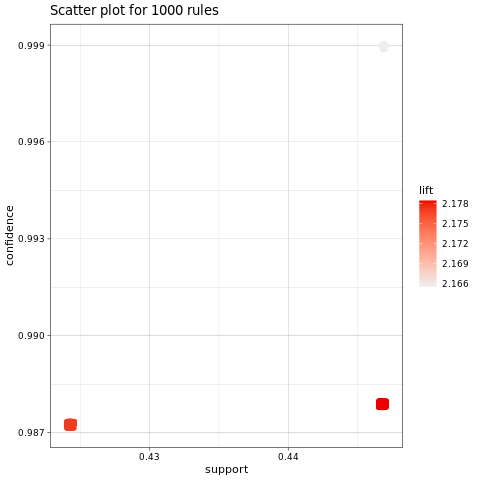

In [290]:
%%R
plot(topRules)

R[write to console]: To reduce overplotting, jitter is added! Use jitter = 0 to prevent jitter.



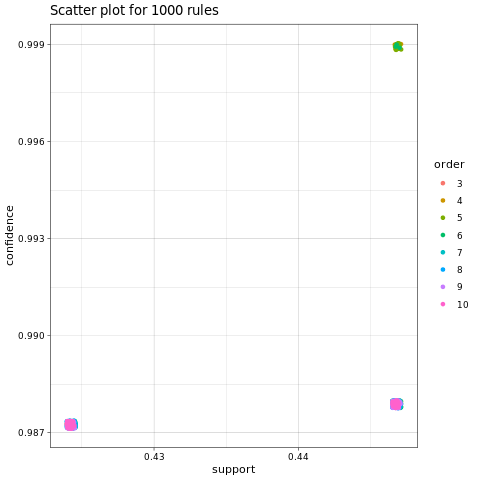

In [291]:
%%R

plot(topRules, method = "two-key plot")

    lhs                                      rhs                                   support confidence coverage     lift count
[1] {bandDistance_speed#6HR#30MIN#ASC=m,                                                                                     
     bandDistance_speed#6HR#30MIN#CID=m}  => {bandDistance_pace#6HR#30MIN#AVG=m} 0.4468985  0.9878809 0.452381 2.178457  2853
NULL


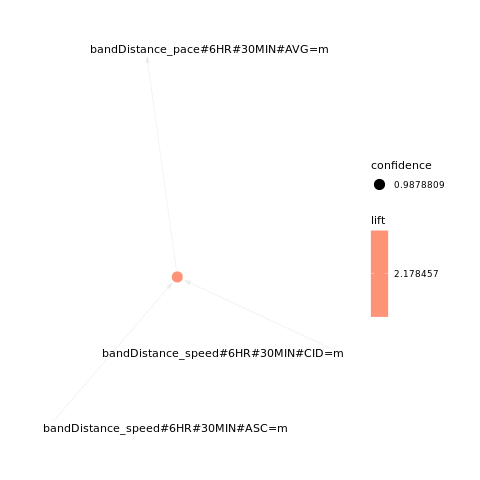

In [294]:
%%R
print(inspect(head(topRules,1)))
plot(head(topRules,1), method = "graph",     measure = "confidence", shading = "lift")



In [ ]:
%%R
saveAsGraph(head(topRules, n = 10, by = "lift"), file = "rules.graphml")

# MLTrainEvalSet

In [295]:
num_interventions= labels_ml.shape[0]
print('there are {:.0f} participants with {} interventions in total'.format( labels_ml.index.get_level_values('pid').nunique(),num_interventions))

there are 38 participants with 1746 interventions in total


In [504]:
test_size = .2
dev_interventions = (1-test_size)*num_interventions
print("Dev:Test = {:.0f}:{:.0f} ".format( dev_interventions, num_interventions-dev_interventions))


val_size = .2
print("Train:Val = {:.0f}:{:.0f} ".format( (1-val_size)*dev_interventions, test_size*dev_interventions))

Dev:Test = 1397:349 
Train:Val = 1117:279 


### Full features

In [326]:
ml_full_features_d={}
windows = {
    '6HR': 6*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=35):    
    for window_name, window_size  in windows.items():
        full_featurs_ml = dataset.parallellize_extract(
            labels=labels_ml, 
            w_name=window_name,
            w_size = window_size,
            use_ray=True            
        )

        
    

2022-01-06 13:08:15,220	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
100%|██████████| 38/38 [05:31<00:00,  8.72s/it]  


#### Select the features

In [334]:
selected_features_mapped_to_fullFeatures = list(map(lambda x: x.replace('30MIN#',''), selected_features_mapped))
full_features_ml = full_features_ml[selected_features_mapped_to_fullFeatures]

#### imputation

In [335]:
full_features_ml.isnull().sum()

activity_event#6HR#ETP                                  40
battery_temperature#6HR#VAR                             32
bandUV_indexLevel#6HR#ETP                               16
bandUV_exposure#6HR#MAX                                 17
data_RX2TX#6HR#ASC                                      32
battery_plugState#6HR#SUP:WIRELESS                    1577
appUsage_appCategory#6HR#SUP:Productivity/Business    1126
location_distance#6HR#CID                               34
data_RX#6HR#CID                                         32
battery_plugState#6HR#SUP:AC                           520
location_cluster#6HR#ETP                                33
bandDistance_speed#6HR#ASC                              16
bandUV_indexLevel#6HR#ASC                               16
battery_status#6HR#ETP                                  32
appUsage_appCategory#6HR#SUP:Social/Communication      110
bandDistance_speed#6HR#CID                              16
data_RX2TX#6HR#CID                                      

In [336]:

full_features_ml = impute_by_filling_support_features(full_features_ml)
full_features_ml.iloc[:,full_features_ml.columns.str.contains('SUP')].std().sum()

  0%|          | 0/38 [00:00<?, ?it/s]/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
100%|██████████| 38/38 [00:00<00:00, 199.48it/s]


0.7692335251374586

In [337]:
df_sub_ml = impute_with_mean_of_participant(df_sub_ml)
df_sub_ml.isnull().sum()

100%|██████████| 38/38 [00:00<00:00, 101.13it/s]


bandGSR_resistance#6HR#30MIN#MAXLAGVAL                      0
bandHeartRate_RRInterval#6HR#30MIN#MAXLAG                   0
bandUV_indexLevel#6HR#30MIN#ETP                             0
bandUV_indexLevel#6HR#30MIN#ASC                             0
bandUV_exposure#6HR#30MIN#MAX                               0
bandUV_exposure#6HR#30MIN#BEP                               0
bandDistance_pace#6HR#30MIN#AVG                             0
bandDistance_speed#6HR#30MIN#ASC                            0
bandDistance_speed#6HR#30MIN#CID                            0
appUsage_appCategory#6HR#30MIN#ETP                          0
battery_temperature#6HR#30MIN#MAX                           0
battery_temperature#6HR#30MIN#VAR                           0
battery_temperature#6HR#30MIN#ASC                           0
battery_temperature#6HR#30MIN#LTI                           0
battery_level#6HR#30MIN#MIN                                 0
battery_level#6HR#30MIN#VAR                                 0
battery_

#### Classification

In [338]:

data = pd.merge(labels_ml[['is_opportune_moment']], full_features_ml, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        939
non-receptive    807
Name: is_opportune_moment, dtype: int64


2022-01-06 13:18:20,074	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
38it [00:00, 202.23it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,53.393124,51.775355


- using reduced ML set

In [346]:


data = pd.merge(labels_ml[['is_opportune_moment']], full_features_ml, left_index=True, right_index=True )
data = pd.merge(data, featuresCFF[[]],left_index=True, right_index=True)# to reduce
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

is_opportune_moment  activity_event#6HR#ETP  \
pid  timestamp                                                         
1510 2019-05-16 11:17:00       non-receptive                     NaN   
     2019-05-16 12:56:00           receptive                     NaN   
     2019-05-16 19:40:00       non-receptive                0.839470   
     2019-05-17 10:43:00           receptive                0.000000   
     2019-05-17 11:28:00       non-receptive                0.000000   
...                                      ...                     ...   
707  2019-05-12 14:15:00           receptive                0.086907   
     2019-05-13 15:59:00       non-receptive                0.328124   
     2019-05-13 16:41:00       non-receptive                0.328124   
     2019-05-13 20:26:00       non-receptive                0.251117   
     2019-05-14 16:41:00           receptive                0.269629   

                          battery_temperature#6HR#VAR  \
pid  timestamp                                          
1510 2019-05-16 11:17:00                          NaN   
     2019-05-16 12:56:00                          NaN   
     2019-05-16 19:40:00                    10.333306   
     2019-05-17 10:43:00                     3.661834   
     2019-05-17 11:28:00                     3.304665   
...                                               ...   
707  2019-05-12 14:15:00                    15.049544   
     2019-05-13 15:59:00                     4.188944   
     2019-05-13 16:41:00                     3.912996   
     2019-05-13 20:26:00                     1.873101   
     2019-05-14 16:41:00                     7.841677   

                          bandUV_indexLevel#6HR#ETP  bandUV_exposure#6HR#MAX  \
pid  timestamp                                                                 
1510 2019-05-16 11:17:00                   0.074876                      0.0   
     2019-05-16 12:56:00                   0.171811                      0.0   
     2019-05-16 19:40:00                   0.000000                      0.0   
     2019-05-17 10:43:00                   0.000000                      0.0   
     2019-05-17 11:28:00                   0.000000                      0.0   
...                                             ...                      ...   
707  2019-05-12 14:15:00                   0.019124                      0.0   
     2019-05-13 15:59:00                   0.000000                      0.0   
     2019-05-13 16:41:00                   0.000000                      0.0   
     2019-05-13 20:26:00                   0.000000                      0.0   
     2019-05-14 16:41:00                   0.000000                      0.0   

                          data_RX2TX#6HR#ASC  \
pid  timestamp                                 
1510 2019-05-16 11:17:00                 NaN   
     2019-05-16 12:56:00                 NaN   
     2019-05-16 19:40:00        10983.043729   
     2019-05-17 10:43:00         8515.951718   
     2019-05-17 11:28:00        10760.760718   
...                                      ...   
707  2019-05-12 14:15:00         5563.476992   
     2019-05-13 15:59:00         1980.211800   
     2019-05-13 16:41:00         2136.159732   
     2019-05-13 20:26:00         1796.623266   
     2019-05-14 16:41:00         4585.495645   

                          battery_plugState#6HR#SUP:WIRELESS  \
pid  timestamp                                                 
1510 2019-05-16 11:17:00                            0.000000   
     2019-05-16 12:56:00                            0.000000   
     2019-05-16 19:40:00                            0.122308   
     2019-05-17 10:43:00                            0.000000   
     2019-05-17 11:28:00                            0.000000   
...                                                      ...   
707  2019-05-12 14:15:00                            0.000000   
     2019-05-13 15:59:00                            0.000000   
     2019-05-13 16:41:00                

receptive        681
non-receptive    625
Name: is_opportune_moment, dtype: int64


2022-01-06 13:37:44,036	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
30it [00:00, 185.56it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,47.56562,47.729201



### Agg 

#### extract sub features
- extract sub features only for selected 


In [297]:
selected_features_mapped[:3]

['activity_event#6HR#30MIN#ETP',
 'battery_temperature#6HR#30MIN#VAR',
 'bandUV_indexLevel#6HR#30MIN#ETP']

In [298]:
ml_sub_features_d={}
windows = {
    '6HR': 6*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=35):    
    for window_name, window_size  in windows.items():
        ml_sub_features_d[window_name] = dataset.parallellize_extract_sub(
            labels=labels_ml, 
            w_name=window_name,
            w_size = window_size,
            selected_features=selected_features_mapped,
            use_ray=True            
        )

        
    

2022-01-06 12:18:40,800	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
 16%|█▌        | 6/38 [03:40<12:26, 23.33s/it]   (pid=3431) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
(pid=3431)   **kwargs)
(pid=3431) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
(pid=3431)   ret = ret.dtype.type(ret / rcount)
(pid=3431) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
(pid=3431)   slope = ssxym / ssxm
(pid=3431) /data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
(pid=3431)   t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
(pid=3431) /data/juma/anacon

In [318]:
df_sub_ml = ml_sub_features_d['6HR']
df_sub_ml.to_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv')
df_sub_ml = pd.read_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv', dtype={'pid':'str'},
                     parse_dates=['timestamp'])
df_sub_ml.set_index(['pid','timestamp','sub_timestamp'], inplace=True)

df_sub_ml

bandGSR_resistance#6HR#30MIN#MAXLAGVAL  \
pid  timestamp           sub_timestamp                                                 
1510 2019-05-16 10:09:00 2019-05-16 04:09:00                                     NaN   
                         2019-05-16 04:39:00                                     NaN   
                         2019-05-16 05:09:00                                     NaN   
                         2019-05-16 05:39:00                                     NaN   
                         2019-05-16 06:09:00                                     NaN   
...                                                                              ...   
707  2019-05-14 16:41:00 2019-05-14 14:11:00                                0.998889   
                         2019-05-14 14:41:00                                0.998889   
                         2019-05-14 15:11:00                                0.998889   
                         2019-05-14 15:41:00                                0.998889   
                         2019-05-14 16:11:00                                0.998889   

                                              bandHeartRate_RRInterval#6HR#30MIN#MAXLAG  \
pid  timestamp           sub_timestamp                                                    
1510 2019-05-16 10:09:00 2019-05-16 04:09:00                                        NaN   
                         2019-05-16 04:39:00                                        NaN   
                         2019-05-16 05:09:00                                        NaN   
                         2019-05-16 05:39:00                                        NaN   
                         2019-05-16 06:09:00                                        NaN   
...                                                                                 ...   
707  2019-05-14 16:41:00 2019-05-14 14:11:00                                        0.0   
                         2019-05-14 14:41:00                                        0.0   
                         2019-05-14 15:11:00                                        0.0   
                         2019-05-14 15:41:00                                        0.0   
                         2019-05-14 16:11:00                                        0.0   

                                              bandUV_indexLevel#6HR#30MIN#ETP  \
pid  timestamp           sub_timestamp                                          
1510 2019-05-16 10:09:00 2019-05-16 04:09:00                              NaN   
                         2019-05-16 04:39:00                              NaN   
                         2019-05-16 05:09:00                              NaN   
                         2019-05-16 05:39:00                              NaN   
                         2019-05-16 06:09:00                              NaN   
...                                                                       ...   
707  2019-05-14 16:41:00 2019-05-14 14:11:00                              0.0   
                         2019-05-14 14:41:00                              0.0   
                         2019-05-14 15:11:00                              0.0   
                         2019-05-14 15:41:00                              0.0   
                         2019-05-14 16:11:00                              0.0   

                                              bandUV_indexLevel#6HR#30MIN#ASC  \
pid  timestamp           sub_timestamp                                          
1510 2019-05-16 10:09:00 2019-05-16 04:09:00                              NaN   
                         2019-05-16 04:39:00                              NaN   
                         2019-05-16 05:09:00                              NaN   
                         2019-05-16 05:39:00                              NaN   
                         2019-05-16 06:09:00                              NaN   
...                                                                       ...   
707  2019-05-14

#### impute

In [319]:

df_sub_ml = impute_by_filling_support_features(df_sub_ml)
df_sub_ml.iloc[:,df_sub_ml.columns.str.contains('SUP')].std().sum()

  0%|          | 0/38 [00:00<?, ?it/s]/data/juma/anaconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 38/38 [00:00<00:00, 152.69it/s]


1.1764081952945167

In [320]:
df_sub_ml = impute_with_mean_of_participant(df_sub_ml)
df_sub_ml.shape

100%|██████████| 38/38 [00:00<00:00, 85.03it/s]


(20952, 30)

In [321]:
agg_feature_ml = df_sub_ml.groupby(['pid','timestamp']).agg(['mean','std'])
agg_feature_ml.columns = agg_feature_ml.columns.map('|'.join).str.strip('|')
agg_feature_ml = drop_zero_varience_features(agg_feature_ml)

0 from total of 60 is dropped


In [324]:
agg_feature_ml

bandGSR_resistance#6HR#30MIN#MAXLAGVAL|mean  \
pid  timestamp                                                          
1510 2019-05-16 10:09:00                                     0.880691   
     2019-05-16 11:17:00                                     0.871573   
     2019-05-16 12:56:00                                     0.916066   
     2019-05-16 19:40:00                                     0.998884   
     2019-05-17 10:43:00                                     0.998561   
...                                                               ...   
729  2019-05-14 18:10:00                                     0.991243   
     2019-05-14 18:53:00                                     0.982673   
     2019-05-14 19:33:00                                     0.985188   
     2019-05-14 20:16:00                                     0.994979   
     2019-05-14 21:02:00                                     0.937456   

                          bandGSR_resistance#6HR#30MIN#MAXLAGVAL|std  \
pid  timestamp                                                         
1510 2019-05-16 10:09:00                                    0.000000   
     2019-05-16 11:17:00                                    0.036182   
     2019-05-16 12:56:00                                    0.055526   
     2019-05-16 19:40:00                                    0.000019   
     2019-05-17 10:43:00                                    0.001137   
...                                                              ...   
729  2019-05-14 18:10:00                                    0.011736   
     2019-05-14 18:53:00                                    0.020581   
     2019-05-14 19:33:00                                    0.018608   
     2019-05-14 20:16:00                                    0.003739   
     2019-05-14 21:02:00                                    0.189518   

                          bandHeartRate_RRInterval#6HR#30MIN#MAXLAG|mean  \
pid  timestamp                                                             
1510 2019-05-16 10:09:00                                        0.000000   
     2019-05-16 11:17:00                                        0.000000   
     2019-05-16 12:56:00                                        0.000000   
     2019-05-16 19:40:00                                        0.000000   
     2019-05-17 10:43:00                                        0.000000   
...                                                                  ...   
729  2019-05-14 18:10:00                                        0.000000   
     2019-05-14 18:53:00                                        0.000000   
     2019-05-14 19:33:00                                        0.083333   
     2019-05-14 20:16:00                                        0.000000   
     2019-05-14 21:02:00                                        0.000000   

                          bandHeartRate_RRInterval#6HR#30MIN#MAXLAG|std  \
pid  timestamp                                                            
1510 2019-05-16 10:09:00                                       0.000000   
     2019-05-16 11:17:00                                       0.000000   
     2019-05-16 12:56:00                                       0.000000   
     2019-05-16 19:40:00                                       0.000000   
     2019-05-17 10:43:00                                       0.000000   
...                                                                 ...   
729  2019-05-14 18:10:00                                       0.000000   
     2019-05-14 18:53:00                                       0.000000   
     2019-05-14 19:33:00                                       0.288675   
     2019-05-14 20:16:00                                       0.000000   
     2019-05-14 21:02:00                                       0.000000   

                          bandUV_indexLevel#6HR#30MIN#ETP|mean  \
pid  timestamp                                                   
1510 2019-05-16 10:09:00                  

#### Classification performance

In [323]:

data = pd.merge(labels_ml[['is_opportune_moment']], agg_feature_ml, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        939
non-receptive    807
Name: is_opportune_moment, dtype: int64


2022-01-06 13:05:25,692	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
38it [00:00, 195.47it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,45.500195,50.665359


- reduced set

In [348]:
data = pd.merge(labels_ml[['is_opportune_moment']], agg_feature_ml, left_index=True, right_index=True )
data = pd.merge(data, featuresCFF[[]],left_index=True, right_index=True)# to reduce
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        681
non-receptive    625
Name: is_opportune_moment, dtype: int64


2022-01-06 13:39:13,377	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
30it [00:00, 172.05it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,42.112005,46.985952


(20952, 30)

### CFF
- impute
- recode

In [ ]:
df_sub_ml = pd.read_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv', dtype={'pid':'str'},
                     parse_dates=['timestamp'])
df_sub_ml.set_index(['pid','timestamp','sub_timestamp'], inplace=True)


df_sub_ml = impute_by_filling_support_features(df_sub_ml)

df_sub_ml.isnull().sum(axis=0).sort_values(ascending=False)

#### recode

In [302]:
df_sub_ml_recoded = [] 
for pid in tqdm(df_sub_ml.index.get_level_values('pid').unique()):    
    res = discretize_df(df_sub_ml.loc[pid],df_sub_ml.columns.tolist(), pid)
    
    df_sub_ml_recoded.append(res)
    
df_sub_ml_recoded = pd.concat(df_sub_ml_recoded)
df_sub_ml_recoded = df_sub_ml_recoded.reset_index().set_index(['pid', 'timestamp','sub_timestamp'])
df_sub_ml_recoded = df_sub_ml_recoded.astype('object').fillna('missing').astype('category')

  8%|▊         | 3/38 [00:00<00:03,  8.94it/s]

The numbers of 1-3 labels of PID1510 are: 17, 1, 12
The numbers of 1-3 labels of PID3023 are: 12, 4, 14
The numbers of 1-3 labels of PID3013 are: 16, 0, 14


 13%|█▎        | 5/38 [00:00<00:03,  9.84it/s]

The numbers of 1-3 labels of PID727 are: 14, 3, 13
The numbers of 1-3 labels of PID710 are: 15, 2, 13
The numbers of 1-3 labels of PID3025 are: 11, 5, 14


 24%|██▎       | 9/38 [00:00<00:02, 10.71it/s]

The numbers of 1-3 labels of PID714 are: 16, 1, 13
The numbers of 1-3 labels of PID702 are: 14, 3, 13
The numbers of 1-3 labels of PID729 are: 15, 1, 14


 29%|██▉       | 11/38 [00:01<00:02, 11.73it/s]

The numbers of 1-3 labels of PID1527 are: 15, 2, 13
The numbers of 1-3 labels of PID1541 are: 15, 5, 10
The numbers of 1-3 labels of PID3029 are: 14, 4, 12


 39%|███▉      | 15/38 [00:01<00:01, 13.33it/s]

The numbers of 1-3 labels of PID716 are: 16, 1, 13
The numbers of 1-3 labels of PID708 are: 15, 2, 13
The numbers of 1-3 labels of PID3041 are: 16, 0, 14
The numbers of 1-3 labels of PID3024 are: 18, 0, 12


 50%|█████     | 19/38 [00:01<00:01, 14.17it/s]

The numbers of 1-3 labels of PID3027 are: 17, 7, 6
The numbers of 1-3 labels of PID709 are: 16, 1, 13
The numbers of 1-3 labels of PID723 are: 11, 5, 14
The numbers of 1-3 labels of PID704 are: 13, 2, 15


 61%|██████    | 23/38 [00:01<00:01, 14.38it/s]

The numbers of 1-3 labels of PID703 are: 11, 6, 13
The numbers of 1-3 labels of PID706 are: 18, 0, 12
The numbers of 1-3 labels of PID722 are: 16, 1, 13


 66%|██████▌   | 25/38 [00:01<00:00, 14.39it/s]

The numbers of 1-3 labels of PID1525 are: 16, 0, 14
The numbers of 1-3 labels of PID1517 are: 16, 2, 12
The numbers of 1-3 labels of PID3030 are: 10, 3, 17
The numbers of 1-3 labels of PID717 are: 15, 1, 14


 76%|███████▋  | 29/38 [00:02<00:00, 14.58it/s]

The numbers of 1-3 labels of PID711 are: 16, 1, 13
The numbers of 1-3 labels of PID3005 are: 16, 1, 13
The numbers of 1-3 labels of PID1522 are: 10, 6, 14


 87%|████████▋ | 33/38 [00:02<00:00, 14.57it/s]

The numbers of 1-3 labels of PID3010 are: 24, 3, 3
The numbers of 1-3 labels of PID3019 are: 14, 3, 13
The numbers of 1-3 labels of PID1516 are: 14, 3, 13
The numbers of 1-3 labels of PID3001 are: 15, 2, 13


 97%|█████████▋| 37/38 [00:02<00:00, 14.85it/s]

The numbers of 1-3 labels of PID1523 are: 14, 5, 11
The numbers of 1-3 labels of PID705 are: 16, 1, 13
The numbers of 1-3 labels of PID713 are: 11, 5, 14
The numbers of 1-3 labels of PID707 are: 16, 1, 13


100%|██████████| 38/38 [00:02<00:00, 13.29it/s]


In [509]:
df_sub_ml_recoded.shape

(20952, 38)

#### extract 

- for each rule
  - select the df that satisfy the context
     - extract Y from contextually filtered subfeatures and add to features


In [339]:
TOPK_RULES = 40
rules_df = pd.read_csv('rules/rules1000-mlen_10.csv', usecols=['rules','lift'], dtype={'lift':float})
rules_df = rules_df.iloc[:TOPK_RULES]
rules_df = rules_df[rules_df.lift>1.05]

#rules_df.rules = rules_df.rules.str.replace('.SUP.','.SUP:').str.replace('.','#')
featuresCFF = pd.DataFrame()# we store CFF here


for i,rule in (rules_df.iterrows()):
    context, y = rule['rules'].split(' => ')
    
    #clean `{`
    context = context[1:-1]    
    y = y[1:-1]
    
    #'BND_DST_PAC#3HR#30MIN#VAR=m' =>'BND_DST_PAC#3HR#30MIN#VAR'
    y=y.split('=')[0]    
    
    # flag the indices that satisfy our context
    index_flag = True
    for c in context.split(','): #'BND_DST_PAC#3HR#30MIN#VAR=m', 'BND_DST_SPD#3HR#30MIN#BEP=m'
        name, val = c.split('=')
        index_flag = index_flag & (df_sub_ml_recoded[name]==val)        
    featuresCFF[f'mean-{y}-context_{context}'] = df_sub_ml[index_flag][y].groupby(['pid','timestamp']).mean()
    featuresCFF[f'std-{y}-context_{context}'] = df_sub_ml[index_flag][y].groupby(['pid','timestamp']).std()
    

In [340]:
featuresCFF.shape # topK =400 rules

(1306, 80)

In [304]:
features.head()

mean-bandDistance_pace#6HR#30MIN#AVG-context_bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                 
1510 2019-05-16 11:17:00                                         250.048078                                                                    
     2019-05-16 12:56:00                                         129.206926                                                                    
     2019-05-16 19:40:00                                           0.000000                                                                    
     2019-05-17 10:43:00                                           0.000000                                                                    
     2019-05-17 11:28:00                                           0.000000                                                                    

                          std-bandDistance_pace#6HR#30MIN#AVG-context_bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                
1510 2019-05-16 11:17:00                                          69.809687                                                                   
     2019-05-16 12:56:00                                          75.606613                                                                   
     2019-05-16 19:40:00                                           0.000000                                                                   
     2019-05-17 10:43:00                                           0.000000                                                                   
     2019-05-17 11:28:00                                           0.000000                                                                   

                          mean-bandDistance_pace#6HR#30MIN#AVG-context_bandUV_indexLevel#6HR#30MIN#ETP=m,bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                                                   
1510 2019-05-16 11:17:00                                         250.048078                                                                                                      
     2019-05-16 12:56:00                                         129.206926                                                                                                      
     2019-05-16 19:40:00                                           0.000000                                                                                                      
     2019-05-17 10:43:00                                           0.000000                                                                                                      
     2019-05-17 11:28:00                                           0.000000                                                                                                      

                          std-bandDistance_pace#6HR#30MIN#AVG-context_bandUV_indexLevel#6HR#30MIN#ETP=m,bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                                                  
1510 2019-05-16 11:17:00                                          69.809687                                                                                                     
     2019-05-16 12:56:00                                          75.606613                                                                                                     
     2019-05-16 19:40:00                                    

In [341]:
featuresCFF = impute_with_mean_of_participant(featuresCFF)


100%|██████████| 30/30 [00:00<00:00, 46.54it/s]


Empty DataFrame
Columns: []
Index: [(1510, 2019-05-16 11:17:00), (1510, 2019-05-16 12:56:00), (1510, 2019-05-16 19:40:00), (1510, 2019-05-17 10:43:00), (1510, 2019-05-17 11:28:00), (1510, 2019-05-17 12:09:00), (1510, 2019-05-17 12:57:00), (1510, 2019-05-17 14:27:00), (1510, 2019-05-17 15:14:00), (1510, 2019-05-17 16:44:00), (1510, 2019-05-17 19:33:00), (1510, 2019-05-18 11:15:00), (1510, 2019-05-18 11:55:00), (1510, 2019-05-18 13:29:00), (1510, 2019-05-18 15:52:00), (1510, 2019-05-18 21:07:00), (1510, 2019-05-19 10:53:00), (1510, 2019-05-19 11:36:00), (1510, 2019-05-19 13:36:00), (1510, 2019-05-19 16:27:00), (1510, 2019-05-19 18:03:00), (1510, 2019-05-19 21:53:00), (1510, 2019-05-20 12:04:00), (1510, 2019-05-20 15:10:00), (1510, 2019-05-20 16:39:00), (1510, 2019-05-20 17:28:00), (1510, 2019-05-21 10:15:00), (1510, 2019-05-21 13:37:00), (1510, 2019-05-21 16:43:00), (1510, 2019-05-22 10:11:00), (1510, 2019-05-22 11:08:00), (1510, 2019-05-22 13:29:00), (1516, 2019-05-16 14:29:00), (1516, 2019-05-16 15:09:00), (1516, 2019-05-16 15:57:00), (1516, 2019-05-16 16:37:00), (1516, 2019-05-16 18:14:00), (1516, 2019-05-16 18:54:00), (1516, 2019-05-16 19:41:00), (1516, 2019-05-16 20:25:00), (1516, 2019-05-16 21:13:00), (1516, 2019-05-16 21:55:00), (1516, 2019-05-17 12:14:00), (1516, 2019-05-17 12:55:00), (1516, 2019-05-17 13:43:00), (1516, 2019-05-17 14:24:00), (1516, 2019-05-17 15:10:00), (1516, 2019-05-17 17:27:00), (1516, 2019-05-17 18:49:00), (1516, 2019-05-17 20:29:00), (1516, 2019-05-17 21:14:00), (1516, 2019-05-18 10:42:00), (1516, 2019-05-18 11:29:00), (1516, 2019-05-18 12:11:00), (1516, 2019-05-18 12:57:00), (1516, 2019-05-18 13:38:00), (1516, 2019-05-18 16:37:00), (1516, 2019-05-18 18:11:00), (1516, 2019-05-18 18:57:00), (1516, 2019-05-18 19:44:00), (1516, 2019-05-18 20:25:00), (1516, 2019-05-18 21:11:00), (1516, 2019-05-19 12:07:00), (1516, 2019-05-19 14:26:00), (1516, 2019-05-19 15:09:00), (1516, 2019-05-19 16:33:00), (1516, 2019-05-19 18:11:00), (1516, 2019-05-19 19:41:00), (1516, 2019-05-19 20:29:00), (1516, 2019-05-19 21:59:00), (1516, 2019-05-20 10:32:00), (1516, 2019-05-20 12:11:00), (1516, 2019-05-20 13:43:00), (1516, 2019-05-20 14:26:00), (1516, 2019-05-20 15:59:00), (1516, 2019-05-20 17:28:00), (1516, 2019-05-20 18:14:00), (1516, 2019-05-20 18:56:00), (1516, 2019-05-20 19:42:00), (1516, 2019-05-20 20:22:00), (1516, 2019-05-20 21:02:00), (1516, 2019-05-20 21:49:00), (1516, 2019-05-21 10:14:00), (1516, 2019-05-21 12:55:00), (1516, 2019-05-21 13:41:00), (1516, 2019-05-21 15:56:00), (1516, 2019-05-21 17:27:00), (1516, 2019-05-21 18:12:00), (1516, 2019-05-21 18:59:00), (1516, 2019-05-21 19:44:00), (1516, 2019-05-21 21:09:00), (1516, 2019-05-22 10:37:00), (1516, 2019-05-22 11:17:00), (1516, 2019-05-22 12:08:00), (1516, 2019-05-22 15:55:00), (1516, 2019-05-22 18:10:00), (1516, 2019-05-22 18:56:00), (1516, 2019-05-22 19:43:00), (1516, 2019-05-22 20:26:00), (1516, 2019-05-22 21:58:00), ...]

[1306 rows x 0 columns]

#### Classifier Performance

In [344]:
data = pd.merge(labels_ml[['is_opportune_moment']], featuresCFF, left_index=True, right_index=True )
data

is_opportune_moment  \
pid  timestamp                                 
1510 2019-05-16 11:17:00       non-receptive   
     2019-05-16 12:56:00           receptive   
     2019-05-16 19:40:00       non-receptive   
     2019-05-17 10:43:00           receptive   
     2019-05-17 11:28:00       non-receptive   
...                                      ...   
707  2019-05-12 14:15:00           receptive   
     2019-05-13 15:59:00       non-receptive   
     2019-05-13 16:41:00       non-receptive   
     2019-05-13 20:26:00       non-receptive   
     2019-05-14 16:41:00           receptive   

                          mean-bandDistance_pace#6HR#30MIN#AVG-context_bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                 
1510 2019-05-16 11:17:00                                         250.048078                                                                    
     2019-05-16 12:56:00                                         129.206926                                                                    
     2019-05-16 19:40:00                                           0.000000                                                                    
     2019-05-17 10:43:00                                           0.000000                                                                    
     2019-05-17 11:28:00                                           0.000000                                                                    
...                                                                     ...                                                                    
707  2019-05-12 14:15:00                                           8.992331                                                                    
     2019-05-13 15:59:00                                           0.000000                                                                    
     2019-05-13 16:41:00                                           0.000000                                                                    
     2019-05-13 20:26:00                                           0.000000                                                                    
     2019-05-14 16:41:00                                           0.000000                                                                    

                          std-bandDistance_pace#6HR#30MIN#AVG-context_bandDistance_speed#6HR#30MIN#ASC=m,bandDistance_speed#6HR#30MIN#CID=m  \
pid  timestamp                                                                                                                                
1510 2019-05-16 11:17:00                                          69.809687                                                                   
     2019-05-16 12:56:00                                          75.606613                                                                   
     2019-05-16 19:40:00                                           0.000000                                                                   
     2019-05-17 10:43:00                                           0.000000                                                                   
     2019-05-17 11:28:00                                           0.000000                                                                   
...                                                                     ...                                                                   
707  2019-05-12 14:15:00                                          25.179918                                                                   
     2019-05-13 15:59:00                                           0.000000                                                                   
     2019-05-13 16:41:00                                           0.000000                      

In [314]:

data = pd.merge(labels_ml[['is_opportune_moment']], features, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        681
non-receptive    625
Name: is_opportune_moment, dtype: int64


2022-01-06 12:47:47,002	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
30it [00:00, 222.27it/s]

start conducting LOSO trials


,ACC,ACC_BAL
CV_TYPE,,
LOSO,50.631212,48.185141


,ACC,ACC_BAL
CV_TYPE,,
LOSO,50.631212,48.185141


### Combining

In [351]:
full_features_ml.shape

(1746, 30)

In [352]:
featuresCFF.shape

(1306, 80)

In [353]:
agg_feature_ml.shape

(1746, 60)

In [349]:
data = pd.merge(full_features_ml, featuresCFF, left_index=True, right_index=True )
data = pd.merge(data, agg_feature_ml, left_index=True, right_index=True )
data = pd.merge(labels_ml[['is_opportune_moment']], data, left_index=True, right_index=True )
data

is_opportune_moment  activity_event#6HR#ETP  \
pid  timestamp                                                         
1510 2019-05-16 11:17:00       non-receptive                     NaN   
     2019-05-16 12:56:00           receptive                     NaN   
     2019-05-16 19:40:00       non-receptive                0.839470   
     2019-05-17 10:43:00           receptive                0.000000   
     2019-05-17 11:28:00       non-receptive                0.000000   
...                                      ...                     ...   
707  2019-05-12 14:15:00           receptive                0.086907   
     2019-05-13 15:59:00       non-receptive                0.328124   
     2019-05-13 16:41:00       non-receptive                0.328124   
     2019-05-13 20:26:00       non-receptive                0.251117   
     2019-05-14 16:41:00           receptive                0.269629   

                          battery_temperature#6HR#VAR  \
pid  timestamp                                          
1510 2019-05-16 11:17:00                          NaN   
     2019-05-16 12:56:00                          NaN   
     2019-05-16 19:40:00                    10.333306   
     2019-05-17 10:43:00                     3.661834   
     2019-05-17 11:28:00                     3.304665   
...                                               ...   
707  2019-05-12 14:15:00                    15.049544   
     2019-05-13 15:59:00                     4.188944   
     2019-05-13 16:41:00                     3.912996   
     2019-05-13 20:26:00                     1.873101   
     2019-05-14 16:41:00                     7.841677   

                          bandUV_indexLevel#6HR#ETP  bandUV_exposure#6HR#MAX  \
pid  timestamp                                                                 
1510 2019-05-16 11:17:00                   0.074876                      0.0   
     2019-05-16 12:56:00                   0.171811                      0.0   
     2019-05-16 19:40:00                   0.000000                      0.0   
     2019-05-17 10:43:00                   0.000000                      0.0   
     2019-05-17 11:28:00                   0.000000                      0.0   
...                                             ...                      ...   
707  2019-05-12 14:15:00                   0.019124                      0.0   
     2019-05-13 15:59:00                   0.000000                      0.0   
     2019-05-13 16:41:00                   0.000000                      0.0   
     2019-05-13 20:26:00                   0.000000                      0.0   
     2019-05-14 16:41:00                   0.000000                      0.0   

                          data_RX2TX#6HR#ASC  \
pid  timestamp                                 
1510 2019-05-16 11:17:00                 NaN   
     2019-05-16 12:56:00                 NaN   
     2019-05-16 19:40:00        10983.043729   
     2019-05-17 10:43:00         8515.951718   
     2019-05-17 11:28:00        10760.760718   
...                                      ...   
707  2019-05-12 14:15:00         5563.476992   
     2019-05-13 15:59:00         1980.211800   
     2019-05-13 16:41:00         2136.159732   
     2019-05-13 20:26:00         1796.623266   
     2019-05-14 16:41:00         4585.495645   

                          battery_plugState#6HR#SUP:WIRELESS  \
pid  timestamp                                                 
1510 2019-05-16 11:17:00                            0.000000   
     2019-05-16 12:56:00                            0.000000   
     2019-05-16 19:40:00                            0.122308   
     2019-05-17 10:43:00                            0.000000   
     2019-05-17 11:28:00                            0.000000   
...                                                      ...   
707  2019-05-12 14:15:00                            0.000000   
     2019-05-13 15:59:00                            0.000000   
     2019-05-13 16:41:00                

In [350]:
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

receptive        681
non-receptive    625
Name: is_opportune_moment, dtype: int64


2022-01-06 13:43:45,833	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
13it [00:00, 125.25it/s]

start conducting LOSO trials


30it [00:00, 138.46it/s]


,ACC,ACC_BAL
CV_TYPE,,
LOSO,48.607912,47.705575
